In [2]:
#base
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import random
#keras
import keras.backend as K
import tensorflow as tf 
#sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
#scipy
from scipy.spatial import distance
from scipy.stats import gmean
from scipy import interpolate 
#biopython
import skbio
from io import StringIO

In [3]:
warnings.filterwarnings('ignore')
sns.set_theme()

# 1. READ AND PREPARE DATA

In [4]:
df = pd.read_csv('rarefied_double_interpolated_feces_male_otu.csv', index_col = [0])

In [6]:
def filter_rare_bacteria(df):
    
    rare_bacteria_df = pd.DataFrame((df == 0).astype(int).sum(axis = 0))
    rare_bacteria_col = rare_bacteria_df[rare_bacteria_df[0] > 250].index
    df_filtered = df.drop(rare_bacteria_col, axis = 1)
    
    return df_filtered

In [9]:
filtered_df = filter_rare_bacteria(df)

In [10]:
filtered_df.shape

(280, 347)

### split to test and train

In [11]:
x_train = filtered_df.iloc[:220]
x_test = filtered_df.iloc[221:]

#### normalize

In [14]:
scaler = MinMaxScaler()

normalized_train = scaler.fit_transform(x_train)
normalized_test = scaler.transform(x_test)

<AxesSubplot:ylabel='Density'>

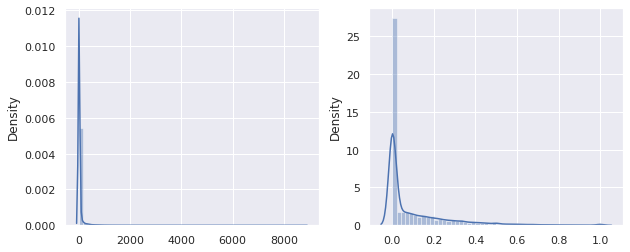

In [10]:
plt.figure(figsize = [10,4])
plt.subplot(1, 2, 1)
sns.distplot(x_train)
plt.subplot(1, 2, 2)
sns.distplot(normalized_train)

# 2. TRAIN AND TEST AUTOENCODER

In [12]:
tree_file = 'tree.nwk'
tree = skbio.tree.TreeNode.read(tree_file)

class Metrics(tf.keras.callbacks.Callback):
    
    def __init__(self, validation_data, scaler, prefix = 'val'):
        self.validation_data = validation_data #podpinamy validation data
        self.scaler = scaler
        self.prefix = prefix
        
        metrics_dict = {}

    def on_epoch_end(self, batch, logs={}):
        
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = self.validation_data[1]
        
        #predict_denorm = np.exp(scaler.inverse_transform(predict)) - 1
        #target_denorm = np.exp(scaler.inverse_transform(targ)) - 1
        
        predict_denorm = scaler.inverse_transform(predict)
        predict_denorm[predict_denorm<0] = 0
        target_denorm = scaler.inverse_transform(targ)
        target_denorm[target_denorm<0] = 0
        
        logs[f'{self.prefix}_cosine_distance'] = np.array([distance.cosine(target_denorm[i], predict_denorm[i]) for i in range(target_denorm.shape[0])]).mean()
        logs[f'{self.prefix}_bray_curtis'] = np.array([distance.braycurtis(target_denorm[i], predict_denorm[i]) for i in range(target_denorm.shape[0])]).mean()
        logs[f'{self.prefix}_weighted_unifrac'] = np.array([skbio.diversity.beta.weighted_unifrac(target_denorm[i], predict_denorm[i],otu_ids=filtered_df.columns, tree=tree) for i in range(target_denorm.shape[0])]).mean()
        
        return

In [16]:
input_size = normalized_train.shape[1]
input_data = tf.keras.Input(shape=(input_size,))

encoded = tf.keras.layers.Dense(504, activation='relu')(input_data)

encoded = tf.keras.layers.Dense(64)(encoded) ##latent, linear act

decoded = tf.keras.layers.Dense(504, activation='relu')(encoded)
#output layer
decoded = tf.keras.layers.Dense(input_size, activation='linear')(decoded)

# Compile model
autoencoder = tf.keras.Model(input_data, decoded)

autoencoder.compile(
    loss = tf.keras.losses.MeanSquaredError(),   
    optimizer='Adam'
)

metrics = Metrics(
    validation_data = (normalized_test, normalized_test),
    scaler=scaler,
    prefix='val'
)
train_metrics = Metrics(
    validation_data = (normalized_train, normalized_train),
    scaler=scaler,
    prefix = 'train'
)

ae_result = autoencoder.fit(
    normalized_train, normalized_train,
    epochs=60,
    batch_size=16,
    shuffle=False,
    validation_data=(normalized_test, normalized_test),
    callbacks = [metrics, train_metrics],
    verbose = 0
)

results_df = pd.DataFrame.from_dict(ae_result.history)
results_df['epochs'] = results_df.index

In [18]:
results_df.to_csv('autoencoders/history/filtered_ae_history.csv')

# 3. PLOT METRICS AND LOSS

In [19]:
def plot_metric(df, metric):
    
    plt.figure(figsize=(8, 4))
    if metric == 'loss':
        
        sns.lineplot(x = df['epochs'], y = df[metric], color = 'black')
        sns.scatterplot(x = df['epochs'], y = df[metric], color = 'black')
        
    else:
        sns.lineplot(x = df['epochs'], y = df['train_' + metric], color = 'black')
        sns.scatterplot(x = df['epochs'], y = df['train_' + metric], color = 'black')
    
    sns.lineplot(x = df['epochs'], y = df['val_'+ metric], color = 'orange')
    sns.scatterplot(x = df['epochs'], y = df['val_'+ metric], color = 'orange')
    
    plt.title('%s on train and test data' % (metric))
    #plt.savefig('plots/filtered_data/filtered_data_{}.png'.format(metric))

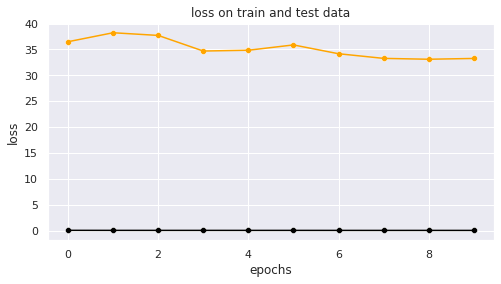

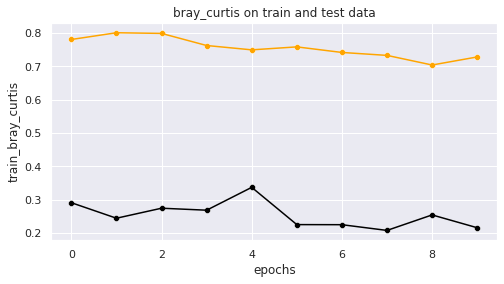

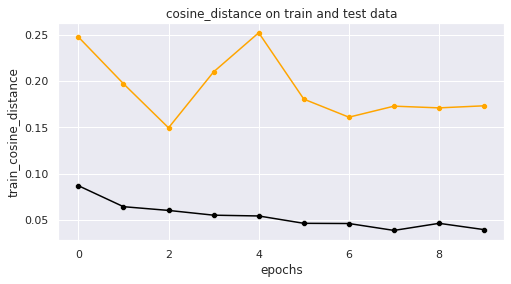

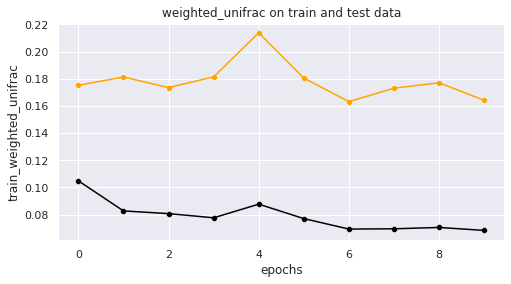

In [20]:
plot_metric(results_df, 'loss')
plot_metric(results_df, 'bray_curtis')
plot_metric(results_df, 'cosine_distance')
plot_metric(results_df, 'weighted_unifrac')

In [24]:
#save ae
autoencoder.save('autoencoders/filtered_data_ae/filtered_data_ae.hdf5')

# 4. EXTRACT LATENT LAYER

In [31]:
#read model
ae = tf.keras.models.load_model('autoencoders/filtered_data_ae/filtered_data_ae.hdf5')

#extract encoder
encoder_model = tf.keras.Model(ae.input, ae.layers[-3].output)
encoded_array = encoder_model.predict(normalized_train)
encoded_df = pd.DataFrame(encoded_array)
encoded_df.index = x_train.index.astype(int)

In [ ]:
#save
X_encode_df.to_csv('encoded_data_for_prediction/filtered_data_encoded.csv',
                   sep = '\t')

# 5. sVAR PREDICTIONS

# 6. EXTRACT DECODER AND DECODE PREDICTION

In [30]:
encoded_prediction_svar1 = pd.read_csv('SVAR_DATA/svar_predictions/filtered_data_ae_predictions_sVAR1.csv')

#read model
ae = tf.keras.models.load_model('autoencoders/filtered_data_ae/filtered_data_ae.hdf5')

#extract decoder
encoding_dim = 64
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder = ae.layers[-2](encoded_input)
decoder = ae.layers[-1](decoder)
decoder_model = tf.keras.Model(encoded_input, decoder)

#predict 
decoded_predicion_svar1 = pd.DataFrame(decoder_model.predict(encoded_prediction_svar1), columns = filtered_df.columns)
decoded_predicion_svar1[decoded_predicion_svar1<0] = 0

In [ ]:
#save
decoded_predicion_svar1.to_csv('decoded_svar_predictions/filtered_svar1_prediction_decoded.csv')